In [7]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline 
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import shap

In [8]:
df = pd.read_csv("final.csv")
df.head()

,TotalRevenue,AvgRevenuePerClaim,RevenueStd,RevenuePerBeneficiary,DeductibleRatio,TotalClaims,UniquePatients,ClaimsPerPatient,InpatientRatio,HighCostRatio,...,AvgLengthOfStay,AvgChronicBurden,ShortNoteRatio,HighCostShortNoteRatio,AvgWordCount,MedicalTermDensity,ClaimAfterDeathCount,AgeStd,RevenueMedianGap,PotentialFraud
0,104640,4185.600000,10796.091144,4185.600000,0.051032,25,24,1.000000,0.200000,0.200000,...,1.440000,1.464000,0.000000,0.000000,537.280000,2.280000,0,11.915256,3785.600000,0
1,605670,4588.409091,7309.794729,5132.796610,0.109442,132,117,1.118644,0.469697,0.469697,...,3.674242,1.553030,0.022727,0.022727,458.977273,2.515152,0,13.461823,2838.409091,1
2,52170,350.134228,689.963754,375.323741,0.005942,149,138,1.071942,0.000000,0.060403,...,1.429530,1.576510,0.006711,0.000000,511.402685,2.751678,0,12.918061,280.134228,0
3,280910,241.124464,491.556392,566.350806,0.013171,1165,495,2.348790,0.000000,0.023176,...,1.088412,1.580601,0.015451,0.000000,486.928755,2.706438,0,13.357434,171.124464,1
4,33710,468.194444,1433.769116,571.355932,0.096823,72,58,1.220339,0.041667,0.055556,...,0.958333,1.600000,0.055556,0.013889,428.208333,2.513889,0,14.628679,388.194444,0


In [9]:
def rule_engine(row):

    if row["ClaimAfterDeathCount"] > 0:
        return "CRITICAL: Billing After Death"

    if row["InpatientRatio"] > 0.98 and row["AvgLengthOfStay"] < 1:
        return "CRITICAL: Impossible Stay Pattern"

    if row["RevenuePerBeneficiary"] > 100000 and row["AvgChronicBurden"] < 0.2:
        return "CRITICAL: Extreme Billing With Low Severity"

    if row["HighCostRatio"] > 0.95:
        return "CRITICAL: Nearly All Claims High Cost"


    if row["ClaimsPerPatient"] > 12:
        return "HIGH: Extreme Repeat Billing"

    if row["RevenueStd"] == 0 and row["TotalClaims"] > 20:
        return "HIGH: Identical Billing Pattern"

    if row["RevenueMedianGap"] > 25000:
        return "HIGH: Severe Cost Skew"

    if row["InpatientRatio"] > 0.85 and row["AvgDiagnosisCount"] < 2:
        return "HIGH: Too Many Admissions Low Diagnosis"

    if row["DeductibleRatio"] < 0.01 and row["TotalRevenue"] > 500000:
        return "HIGH: Suspicious Deductible Pattern"

    if row["UniquePatients"] < 10 and row["TotalClaims"] > 200:
        return "HIGH: Few Patients Too Many Claims"

   
    if row["ShortNoteRatio"] > 0.75:
        return "MEDIUM: Weak Documentation"

    if row["MedicalTermDensity"] < 1.5:
        return "MEDIUM: Low Clinical Language"

    if row["AvgWordCount"] < 10 and row["AvgRevenuePerClaim"] > 20000:
        return "MEDIUM: Expensive Claims Poor Notes"

    if row["AgeStd"] < 2 and row["TotalClaims"] > 100:
        return "MEDIUM: Unnatural Patient Demographics"

    if row["AvgProcedureCount"] > 6 and row["AvgDiagnosisCount"] < 2:
        return "MEDIUM: Too Many Procedures Few Diagnoses"

    if row["RevenuePerBeneficiary"] > 50000 and row["ClaimsPerPatient"] > 6:
        return "MEDIUM: High Spending + High Frequency"

    if row["AvgLengthOfStay"] > 15:
        return "MEDIUM: Long Stay Pattern"

    if row["HighCostRatio"] > 0.6 and row["AvgChronicBurden"] < 0.3:
        return "MEDIUM: High Cost Low Complexity"

    return "PASS"

In [10]:

df["RuleFlag"] = df.apply(rule_engine, axis=1)

rule_fail = df[df["RuleFlag"] != "PASS"]
rule_pass = df[df["RuleFlag"] == "PASS"]

In [11]:
X = rule_pass.drop(columns=["PotentialFraud","RuleFlag"])
y = rule_pass["PotentialFraud"]

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

models = [
    LogisticRegression(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    XGBClassifier(
        n_estimators=300,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        eval_metric="logloss",
        use_label_encoder=False
    )
    
]

In [13]:
for i in models:
    pipeline = Pipeline([
    ("imputer",SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler()),
    ("model", i)
    ])
    
    pipeline.fit(X_train, y_train)
    pred = pipeline.predict(X_test)
    prob = pipeline.predict_proba(X_test)[:,1]
    print(classification_report(y_test, pred))
    print("ROC AUC:", roc_auc_score(y_test, prob))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       900
           1       0.85      0.55      0.67       103

    accuracy                           0.94      1003
   macro avg       0.90      0.77      0.82      1003
weighted avg       0.94      0.94      0.94      1003

ROC AUC: 0.9399568500539375
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       900
           1       0.59      0.59      0.59       103

    accuracy                           0.92      1003
   macro avg       0.77      0.77      0.77      1003
weighted avg       0.92      0.92      0.92      1003

ROC AUC: 0.7727831715210356
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       900
           1       0.76      0.57      0.65       103

    accuracy                           0.94      1003
   macro avg       0.85      0.78      0.81      1003
weighted avg      

C:\Users\sriti\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:199: UserWarning: [18:01:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0       0.96      0.98      0.97       900
           1       0.75      0.60      0.67       103

    accuracy                           0.94      1003
   macro avg       0.85      0.79      0.82      1003
weighted avg       0.93      0.94      0.94      1003

ROC AUC: 0.9339374325782093


In [14]:
importance = pd.Series(
    pipeline.named_steps["model"].feature_importances_,
    index=X.columns
)

importance.sort_values(ascending=False)

TotalRevenue              0.320688
RevenuePerBeneficiary     0.060535
TotalClaims               0.055684
RevenueStd                0.052259
ClaimsPerPatient          0.041770
AvgProcedureCount         0.035324
DeductibleRatio           0.035259
AvgLengthOfStay           0.033765
AvgDiagnosisCount         0.033355
AgeStd                    0.032514
RevenueMedianGap          0.031500
AvgWordCount              0.031292
AvgRevenuePerClaim        0.030959
ShortNoteRatio            0.030799
UniquePatients            0.030562
HighCostRatio             0.030106
HighCostShortNoteRatio    0.030008
InpatientRatio            0.029523
AvgChronicBurden          0.027783
MedicalTermDensity        0.026314
ClaimAfterDeathCount      0.000000
dtype: float32

In [15]:
explainer = shap.Explainer(
    pipeline.named_steps["model"],
    X_train
)

shap_values = explainer(X_test)

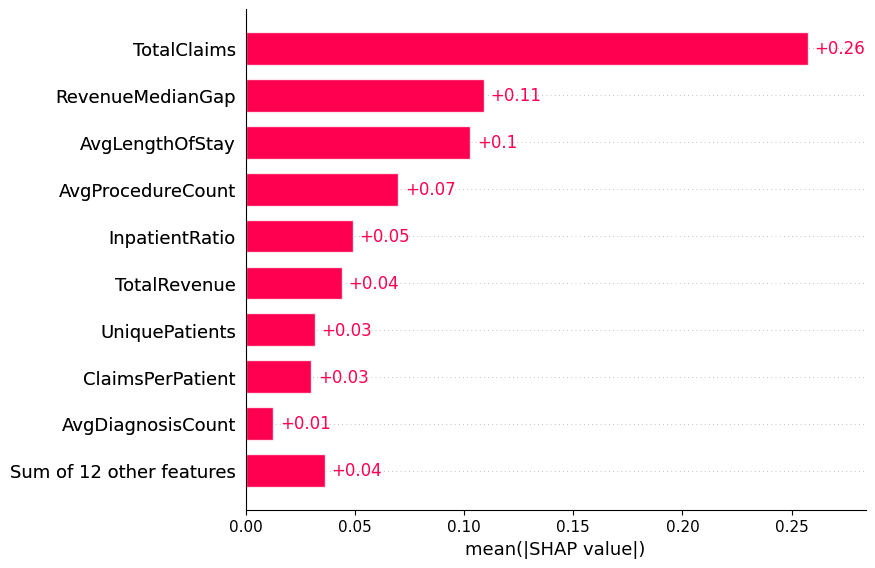

In [16]:
shap.plots.bar(shap_values)

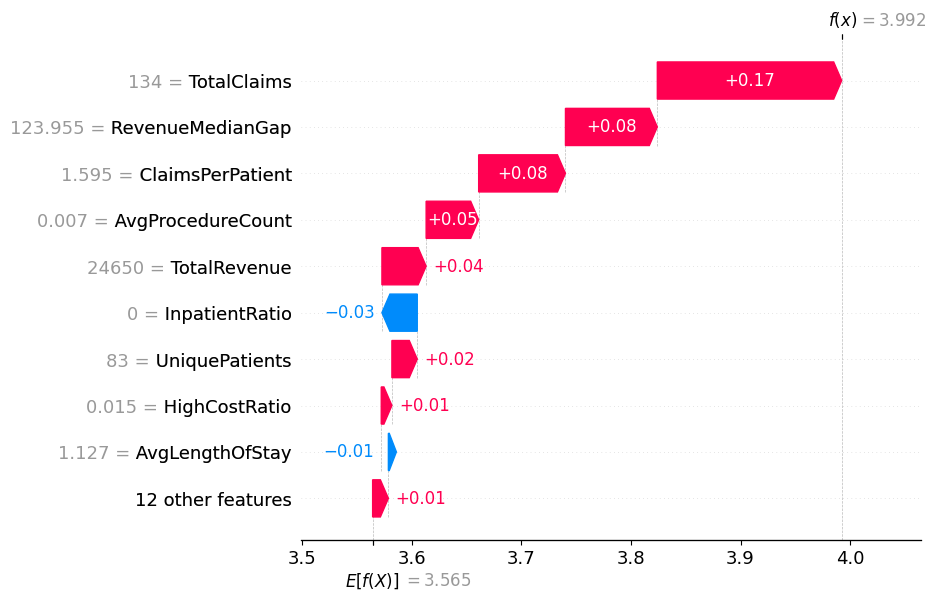

In [17]:
shap.plots.waterfall(shap_values[0])

In [18]:
df["RiskScore"] = pipeline.predict_proba(
    df[X.columns]
)[:,1]

In [19]:
def final_decision(row):

    if row["RuleFlag"] != "PASS":
        return row["RuleFlag"]

    if row["RiskScore"] > 0.80:
        return "ML HIGH RISK"

    if row["RiskScore"] > 0.60:
        return "ML MEDIUM RISK"

    return "LOW RISK"

df["FinalDecision"] = df.apply(final_decision, axis=1)

In [20]:
df.to_csv("fraud_predictions.csv", index=False)